In [9]:
#Import dependencies
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
import datetime
import scipy.stats as stats
from scipy.stats import linregress

In [10]:
#Dave's Code

#Import EPA data, read into dataframe
epa_source = "epa_data/annual_aqi_by_county_all.csv"
epa_data = pd.read_csv(epa_source, index_col=0)

In [11]:
#Add a column for the common pollutant name, based on which of the days values had the largest number
epa_data['Common Pollutant'] = epa_data[['Days CO','Days NO2','Days Ozone','Days SO2','Days PM2.5','Days PM10']].idxmax(1).str.replace('Days ','')

#Add columns to the dataframe for percentages of types of days to give all rows a consistent frame of measure
epa_data['Pct Good Days'] = epa_data['Good Days'] / epa_data['Days with AQI']
epa_data['Pct Moderate Days'] = epa_data['Moderate Days'] / epa_data['Days with AQI'] 
epa_data['Pct Unhealthy for Sensitive Groups Days'] = epa_data['Unhealthy for Sensitive Groups Days'] / epa_data['Days with AQI'] 
epa_data['Pct Unhealthy Days'] = epa_data['Unhealthy Days'] / epa_data['Days with AQI'] 
epa_data['Pct Very Unhealthy Days'] = epa_data['Very Unhealthy Days'] / epa_data['Days with AQI'] 
epa_data['Pct Hazardous Days'] = epa_data['Hazardous Days'] / epa_data['Days with AQI'] 
epa_data.head()

epa_data.head()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,...,Days SO2,Days PM2.5,Days PM10,Common Pollutant,Pct Good Days,Pct Moderate Days,Pct Unhealthy for Sensitive Groups Days,Pct Unhealthy Days,Pct Very Unhealthy Days,Pct Hazardous Days
0,Alabama,Baldwin,2012,284,226,56,2,0,0,0,...,0,74,0,Ozone,0.795775,0.197183,0.007042,0.0,0.0,0.0
1,Alabama,Clay,2012,121,99,22,0,0,0,0,...,0,121,0,PM2.5,0.818182,0.181818,0.000000,0.0,0.0,0.0
2,Alabama,Colbert,2012,283,222,55,6,0,0,0,...,0,74,0,Ozone,0.784452,0.194346,0.021201,0.0,0.0,0.0
3,Alabama,DeKalb,2012,361,282,74,5,0,0,0,...,0,41,0,Ozone,0.781163,0.204986,0.013850,0.0,0.0,0.0
4,Alabama,Elmore,2012,245,212,33,0,0,0,0,...,0,0,0,Ozone,0.865306,0.134694,0.000000,0.0,0.0,0.0


In [24]:
#Export the munged EPA dataframe to a new CSV
epa_data.to_csv("epa_data/annual_aqi_by_county_all_munged.csv", sep=",", index=False, encoding='utf-8')

In [12]:
#Drop the rows containing data for Mexico and the Virgin Islands, since these are not in our Census data
epa_data = epa_data[epa_data["State"] != 'Country Of Mexico']
epa_data = epa_data[epa_data["State"] != 'Virgin Islands']

In [13]:
#Create a summary dataframe for year and common pollutant, counting the number of counties per year/pollutant
pollution_type_count = pd.DataFrame(epa_data.groupby(['Year','Common Pollutant'])['County'].count())

#Reset the index after the group by
pollution_type_count.reset_index(inplace = True)

#Pivot the dataframe, with year as the index and pollutants as the columns
pollution_type_count_pivot = pollution_type_count.pivot(index='Year', columns='Common Pollutant', values='County')

#Sort the pollutant types columns
pollution_type_count_pivot = pollution_type_count_pivot[['Ozone', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO']]

#display the pivot
pollution_type_count_pivot

Common Pollutant,Ozone,PM2.5,PM10,SO2,NO2,CO
Year,,,,,,
2012,609,363,52,34,6,3
2013,583,392,49,29,3,2
2014,585,389,42,28,4,2
2015,595,390,39,30,3,1
2016,655,318,39,32,6,1
2017,660,312,34,44,6,1


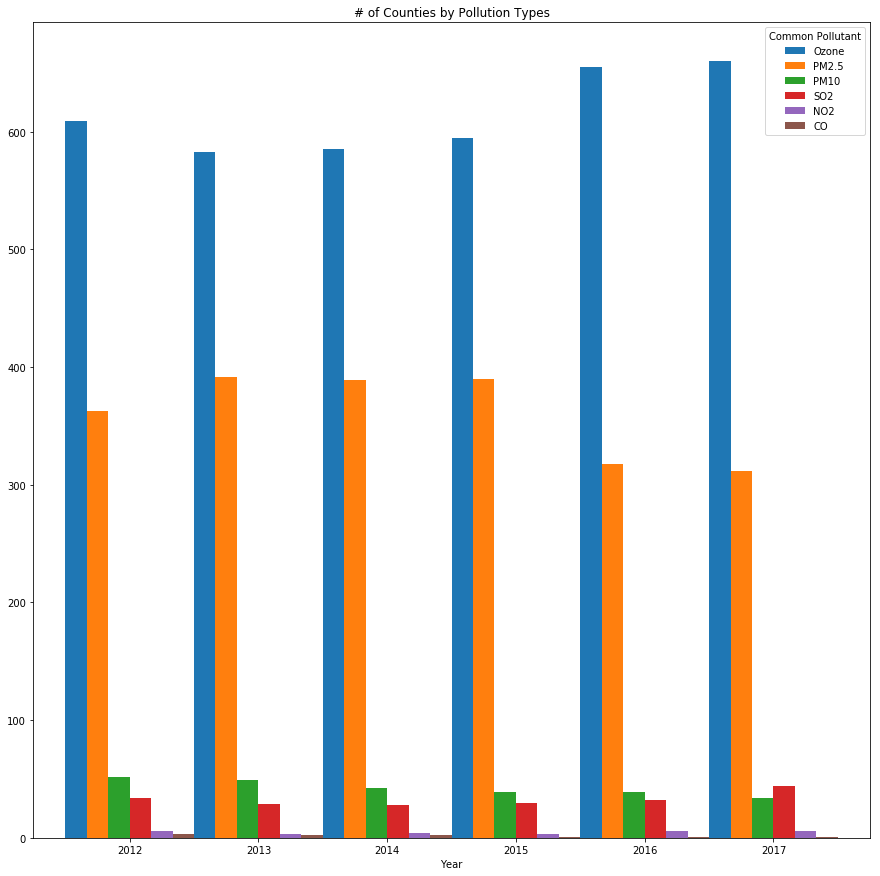

In [14]:
pollution_type_count_pivot.sort_values(by=['Year'], ascending=True).plot(kind='bar',width=1,stacked=False,figsize=(15,15),rot=0,title="# of Counties by Pollution Types")

In [15]:
#Create a dataframe organized by state and the average percentages of each of the AQI levels
epa_data_state_pcts = epa_data.groupby(['State'])['Pct Good Days', 'Pct Moderate Days',
       'Pct Unhealthy for Sensitive Groups Days', 'Pct Unhealthy Days',
       'Pct Very Unhealthy Days', 'Pct Hazardous Days'].mean()
#Print the dataframe
epa_data_state_pcts.head()

,Pct Good Days,Pct Moderate Days,Pct Unhealthy for Sensitive Groups Days,Pct Unhealthy Days,Pct Very Unhealthy Days,Pct Hazardous Days
State,,,,,,
Alabama,0.810722,0.184763,0.004152,0.000336,0.000027,0.000000
Alaska,0.869871,0.106059,0.012237,0.011416,0.000417,0.000000
Arizona,0.620954,0.315888,0.053046,0.008111,0.000807,0.000421
Arkansas,0.815497,0.181635,0.002591,0.000277,0.000000,0.000000
California,0.582489,0.332083,0.066943,0.016144,0.001303,0.000378


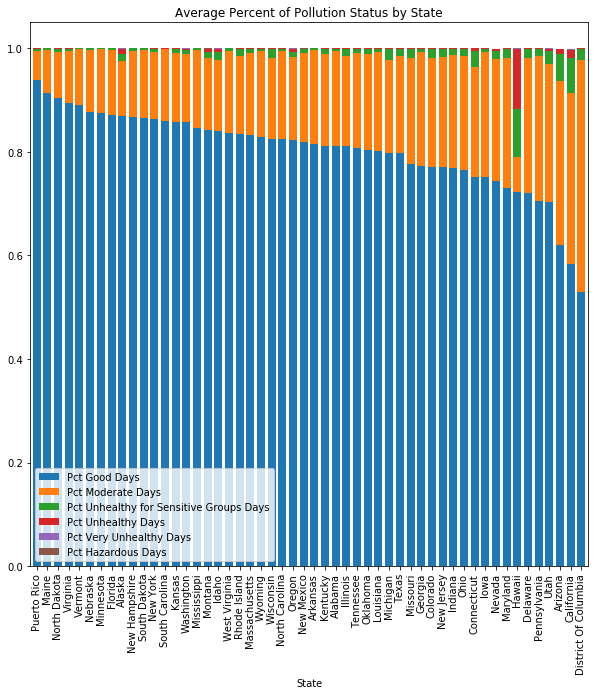

In [16]:
#Plot the dataframe as stacked bar chart
epa_data_state_pcts.sort_values(by='Pct Good Days', ascending=False).plot(kind='bar',stacked=True,width=.75,figsize=(10,10),rot=90,title="Average Percent of Pollution Status by State")

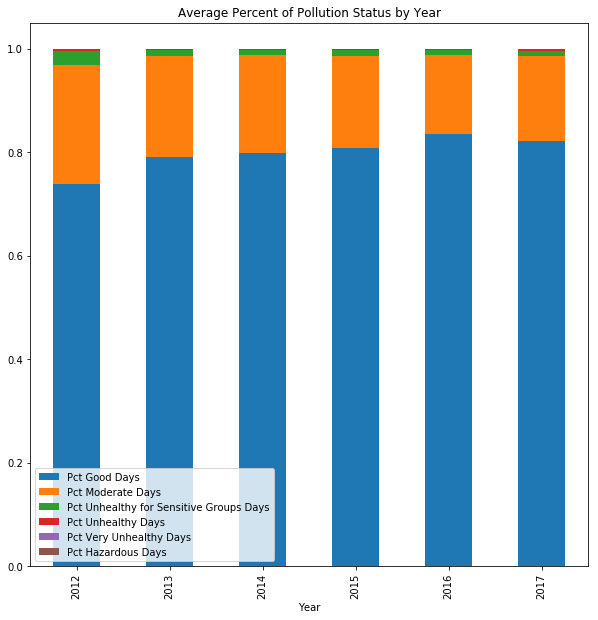

In [17]:
#Create a dataframe organized by Year and the average percentages of each of the AQI levels
epa_data_year_pcts = epa_data.groupby(['Year'])['Pct Good Days', 'Pct Moderate Days',
       'Pct Unhealthy for Sensitive Groups Days', 'Pct Unhealthy Days',
       'Pct Very Unhealthy Days', 'Pct Hazardous Days'].mean()
#Plot the dataframe as stacked bar chart
epa_data_year_pcts.sort_values(by='Year', ascending=True).plot(kind='bar',stacked=True,figsize=(10,10),rot=90,title="Average Percent of Pollution Status by Year")

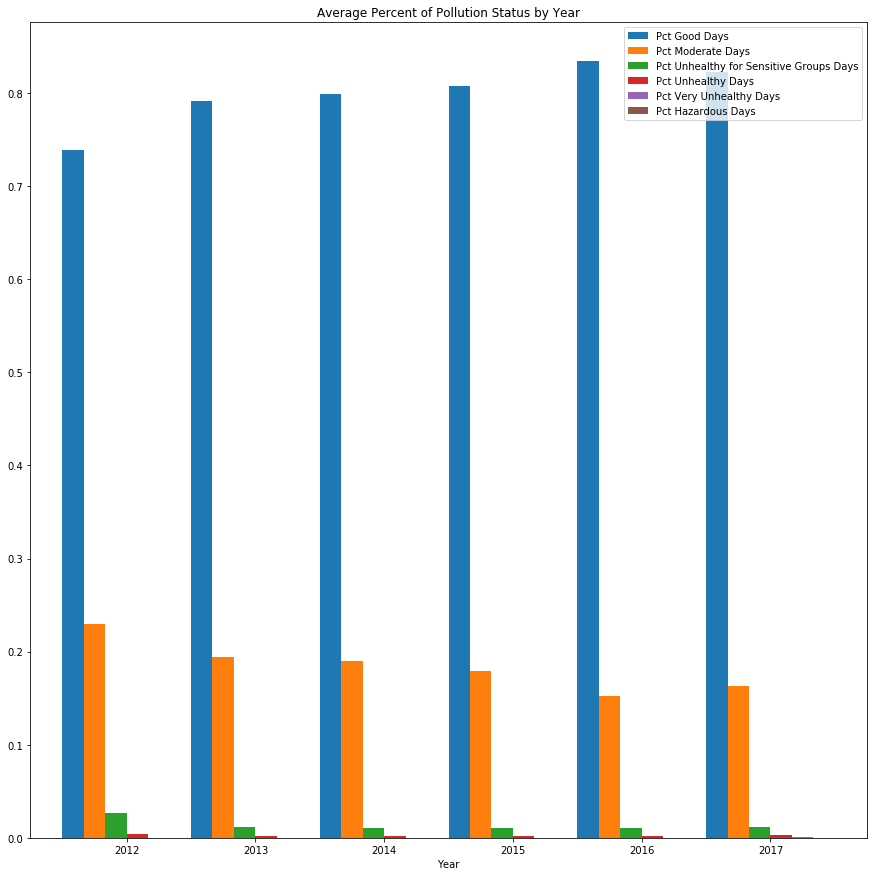

In [18]:
#Plot the dataframe as a bar chart
epa_data_year_pcts.sort_values(by='Year', ascending=True).plot(kind='bar',stacked=False,width=1,figsize=(15,15),rot=0,title="Average Percent of Pollution Status by Year")

In [19]:
# Scott's Code
#import the csv file of combined census and epa data
full_data = pd.read_csv ("census_and_epa.csv")
# calculate the percentage of the number of good days per row
full_data["Percent Good"] = (full_data["Good Days"] / full_data["Days with AQI"]) * 100

In [20]:
#make state code a string and two digits by adding a zero in front of the codes that have only one digit
full_data['FIPSstate'] = full_data['State Code'].astype(str).str.zfill(2)

#make country code a string and three digits by adding zeroes in front of the codes that have less than three
full_data["FIPScnty"] = full_data["County Code"].astype(str).str.zfill(3)

#combine new FIPSstate and FIPScnty codes to make the FIPS code to fill in state/county info on a map
full_data["FIPS"] = full_data["FIPSstate"] + full_data["FIPScnty"]

full_data = full_data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
full_data

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,...,PctBelowPoverty Male,PctBelowPoverty Female,PctBelowPoverty 16 and Over,PctBelowPoverty 16 and Over Employed,State Code,County Code,Percent Good,FIPSstate,FIPScnty,FIPS
0,Alabama,Baldwin,2012,284,226,56,2,0,0,0,...,NaN,NaN,20.1,22.8,1,3,79.577465,01,003,01003
1,Alabama,DeKalb,2012,361,282,74,5,0,0,0,...,NaN,NaN,36.6,31.7,1,49,78.116343,01,049,01049
2,Alabama,Elmore,2012,245,212,33,0,0,0,0,...,NaN,NaN,14.5,11.8,1,51,86.530612,01,051,01051
3,Alabama,Etowah,2012,277,229,48,0,0,0,0,...,NaN,NaN,40.5,41.0,1,55,82.671480,01,055,01055
4,Alabama,Houston,2012,284,238,46,0,0,0,0,...,NaN,NaN,38.4,31.9,1,69,83.802817,01,069,01069
5,Alabama,Jefferson,2012,366,148,198,16,4,0,0,...,NaN,12.5,42.2,41.5,1,73,40.437158,01,073,01073
6,Alabama,Madison,2012,338,242,82,14,0,0,0,...,NaN,NaN,31.9,26.9,1,89,71.597633,01,089,01089
7,Alabama,Mobile,2012,284,229,52,3,0,0,0,...,NaN,13.8,39.4,27.3,1,97,80.633803,01,097,01097
8,Alabama,Montgomery,2012,280,211,68,1,0,0,0,...,NaN,NaN,40.1,31.7,1,101,75.357143,01,101,01101
9,Alabama,Morgan,2012,283,218,59,6,0,0,0,...,NaN,NaN,33.4,29.8,1,103,77.031802,01,103,01103


In [21]:
#create data frames to isolate data by year from 2012 - 2017

twenty_twelve = full_data.query("Year == 2012")
twenty_seventeen = full_data.query("Year == 2017")

In [ ]:
# CREATE MAPS OF PERCENT GOOD AQI DAYS FOR EACH YEAR OF DATA

# create US map of 2012 percent good AQI days
colorscale=[ 'rgb(215,48,39)',
             'rgb(244,109,67)',
             'rgb(253,174,97)',
             'rgb(254,224,144)',
             'rgb(224,243,248)',
             'rgb(171,217,233)',
             'rgb(116,173,209)',
             'rgb(69,117,180)',
             ]

endpts = list(np.linspace(1, 100, len(colorscale) -1))
fips = twenty_twelve['FIPS'].tolist()
values = twenty_twelve['Percent Good'].tolist()

fig = ff.create_choropleth(
    fips=fips, values=values,
    binning_endpoints=endpts,
    colorscale=colorscale,
    show_state_data=True,
    show_hover=True, centroid_marker={'opacity': 0},
    asp=2.9, title='2012 -- % Good AQI Days',
    legend_title='Percent Range'
)
py.offline.plot(fig, filename='2012PctGoodAQIDays')

In [ ]:
# create US map of 2017 percent good AQI days
colorscale = ['rgb(215,48,39)',
             'rgb(244,109,67)',
             'rgb(253,174,97)',
             'rgb(254,224,144)',
             'rgb(224,243,248)',
             'rgb(171,217,233)',
             'rgb(116,173,209)',
             'rgb(69,117,180)',
             ]
endpts = list(np.linspace(1, 100, len(colorscale) - 1))
fips = twenty_seventeen['FIPS'].tolist()
values = twenty_seventeen['Percent Good'].tolist()

fig = ff.create_choropleth(
    fips=fips, values=values,
    binning_endpoints=endpts,
    colorscale=colorscale,
    show_state_data=True,
    show_hover=True, centroid_marker={'opacity': 0},
    asp=2.9, title='2017 -- % Good AQI Days',
    legend_title='Percent Range'
)
py.offline.plot(fig, filename='2017PctGoodAQIDays')

CHARTING POVERTY DATA BY YEAR

In [ ]:
# create percent below poverty level for ages 16 and up for each year
#2012 percent below poverty level ages 16 and up
colorscale = ["#f7fbff","#ebf3fb","#deebf7","#d2e3f3","#c6dbef","#b3d2e9","#9ecae1",
               "#85bcdb","#6baed6","#57a0ce","#4292c6","#3082be","#2171b5","#1361a9",
               "#08519c","#0b4083","#08306b"] 
endpts = list(np.linspace(1, 100, len(colorscale) - 1))
fips = twenty_twelve['FIPS'].tolist()
values = twenty_twelve['PctBelowPoverty 16 and Over'].tolist()

fig = ff.create_choropleth(
    fips=fips, values=values,
    binning_endpoints=endpts,
    colorscale=colorscale,
    show_state_data=True,
    show_hover=True, centroid_marker={'opacity': 0},
    asp=2.9, title='2012 -- % Below Poverty Level Age 16 and Over',
    legend_title='Percent Range'
)
py.offline.plot(fig, filename='2012PctBelowPoverty16up')

In [ ]:
#2017 percent below poverty level ages 16 and up
colorscale = ["#f7fbff","#ebf3fb","#deebf7","#d2e3f3","#c6dbef","#b3d2e9","#9ecae1",
               "#85bcdb","#6baed6","#57a0ce","#4292c6","#3082be","#2171b5","#1361a9",
               "#08519c","#0b4083","#08306b"] 
endpts = list(np.linspace(1, 100, len(colorscale) - 1))
fips = twenty_seventeen['FIPS'].tolist()
values = twenty_seventeen['PctBelowPoverty 16 and Over'].tolist()

fig = ff.create_choropleth(
    fips=fips, values=values,
    binning_endpoints=endpts,
    colorscale=colorscale,
    show_state_data=True,
    show_hover=True, centroid_marker={'opacity': 0},
    asp=2.9, title='2017 -- % Below Poverty Level Age 16 and Over',
    legend_title='Percent Range'
)
py.offline.plot(fig, filename='2017PctBelowPoverty16up')

In [22]:
#Doug's Code
# read in a dataframe and make a new column on this dataframe 
df = pd.read_csv("census_and_epa.csv")
df['PercentGoodDays'] = 100 * df['Good Days']/df['Days with AQI']

In [23]:
# Perform a linear regression on air quality and poverty variables and print the results
slope, intercept, r_value, p_value, std_err = linregress(df['PercentGoodDays'], df['PctBelowPoverty Population'])
print(f'slope: {slope}, intercept: {intercept}, r-value: {r_value}, p-value: {p_value},\nstandard error: {std_err}')

slope: -0.036057985212845915, intercept: 17.458817072809847, r-value: -0.1016960290788303, p-value: 7.028437507760651e-10,
standard error: 0.005832806007403754


Slope Interpretation¶

An increase in PercentGoodDays by 10% corresponds to a 3.6 percent decrease in the percent below poverty threshold

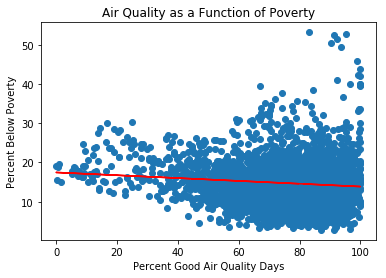

In [24]:
# Plot the relationship between air quality and poverty variables
plt.plot(df['PercentGoodDays'], df['PctBelowPoverty Population'], 'o', label='original data')
plt.plot(df['PercentGoodDays'], intercept + slope*df['PercentGoodDays'], 'r', label='fitted line')
plt.xlabel("Percent Good Air Quality Days")
plt.ylabel("Percent Below Poverty")
plt.title("Air Quality as a Function of Poverty")

plt.show()

In [25]:
# Examine this relationship for a single year
df_2012 = df[df['Year'] == 2012]
slope_12, intercept_12, r_value_12, p_value_12, std_err_12 = linregress(df_2012['PercentGoodDays'], df_2012['PctBelowPoverty Population'])

slope: -0.018876327388561782, intercept: 16.9663280084511, r-value: -0.054256418772535016, p-value: 0.1797347127999716,
standard error: 0.014054182851065862

the slope of the fitted line is not significantly different from zero for the 2012 data


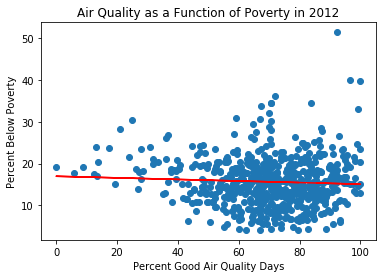

In [26]:
# Plot this relationship for a single year
plt.plot(df_2012['PercentGoodDays'], df_2012['PctBelowPoverty Population'], 'o', label='original data')
plt.plot(df_2012['PercentGoodDays'], intercept_12 + slope_12*df_2012['PercentGoodDays'], 'r', label='fitted line')
plt.xlabel("Percent Good Air Quality Days")
plt.ylabel("Percent Below Poverty")
plt.title("Air Quality as a Function of Poverty in 2012")

print(f'slope: {slope_12}, intercept: {intercept_12}, r-value: {r_value_12}, p-value: {p_value_12},\nstandard error: {std_err_12}')
print(f'\nthe slope of the fitted line is not significantly different from zero for the 2012 data')

slope: -0.027743549373413594, intercept: 15.404087676857682, r-value: -0.07718122233134318, p-value: 0.05655482981975833,
standard error: 0.014522598198439634

the slope of the fitted line is not significantly different from zero for the 2017 data


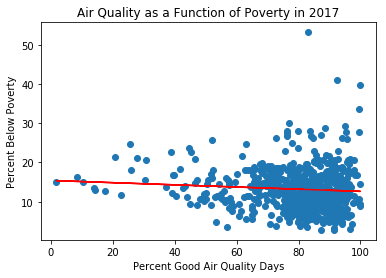

In [73]:
#Examine and plot this relationship for another year
df_2017 = df[df['Year'] == 2017]
slope_17, intercept_17, r_value_17, p_value_17, std_err_17 = linregress(df_2017['PercentGoodDays'], df_2017['PctBelowPoverty Population'])
plt.plot(df_2017['PercentGoodDays'], df_2017['PctBelowPoverty Population'], 'o', label='original data')
plt.plot(df_2017['PercentGoodDays'], intercept_17 + slope_17*df_2017['PercentGoodDays'], 'r', label='fitted line')
plt.xlabel("Percent Good Air Quality Days")
plt.ylabel("Percent Below Poverty")
plt.title("Air Quality as a Function of Poverty in 2017")

print(f'slope: {slope_17}, intercept: {intercept_17}, r-value: {r_value_17}, p-value: {p_value_17},\nstandard error: {std_err_17}')
print(f'\nthe slope of the fitted line is not significantly different from zero for the 2017 data')

In [38]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import rankdata
from scipy.stats import kendalltau

def compute_correlations_by_year(df):
    years = df.Year.unique()
    
    for year in years:
        df_year = df[df.Year == year]
        df_clean = df_year[['PercentGoodDays', 'PctBelowPoverty Population']].dropna()
        n = df_clean.shape[0]
        rval, pval = pearsonr(df_clean['PercentGoodDays'], df_clean['PctBelowPoverty Population'])
        print(f"Year: {year}, nobs: {n}, Pearson's r: {rval:.2f}, p-value: {pval:.2f}")
        rval, pval = spearmanr(df_clean['PercentGoodDays'], df_clean['PctBelowPoverty Population'])
        print(f"Year: {year}, nobs: {n}, Spearman's r: {rval:.2f}, p-value: {pval:.2f}")
        x = rankdata(df_clean['PercentGoodDays'])
        y = rankdata(df_clean['PctBelowPoverty Population'])
        rval, pval = kendalltau(x, y)
        print(f"Year: {year}, nobs: {n}, Kendall's tau: {rval:.2f}, p-value: {pval:.2f}")

compute_correlations_by_year(df)

Year: 2012, nobs: 613, Pearson's r: -0.05, p-value: 0.18
Year: 2012, nobs: 613, Spearman's r: -0.05, p-value: 0.24
Year: 2012, nobs: 613, Kendall's tau: -0.03, p-value: 0.25
Year: 2013, nobs: 608, Pearson's r: -0.08, p-value: 0.05
Year: 2013, nobs: 608, Spearman's r: -0.05, p-value: 0.23
Year: 2013, nobs: 608, Kendall's tau: -0.03, p-value: 0.22
Year: 2014, nobs: 607, Pearson's r: -0.12, p-value: 0.00
Year: 2014, nobs: 607, Spearman's r: -0.08, p-value: 0.04
Year: 2014, nobs: 607, Kendall's tau: -0.06, p-value: 0.04
Year: 2015, nobs: 611, Pearson's r: -0.09, p-value: 0.03
Year: 2015, nobs: 611, Spearman's r: -0.07, p-value: 0.09
Year: 2015, nobs: 611, Kendall's tau: -0.05, p-value: 0.09
Year: 2016, nobs: 609, Pearson's r: -0.06, p-value: 0.13
Year: 2016, nobs: 609, Spearman's r: -0.03, p-value: 0.45
Year: 2016, nobs: 609, Kendall's tau: -0.02, p-value: 0.45
Year: 2017, nobs: 611, Pearson's r: -0.08, p-value: 0.06
Year: 2017, nobs: 611, Spearman's r: -0.10, p-value: 0.02
Year: 2017, nob

In [39]:
# With all years combined we see a significant, small, negative association between
# PercentGoodDays and PctBelowPoverty Population

def compute_all_years_correlations(df):
    df_clean = df[['PercentGoodDays', 'PctBelowPoverty Population']].dropna()
    n = df_clean.shape[0]
    rval, pval = pearsonr(df_clean['PercentGoodDays'], df_clean['PctBelowPoverty Population'])
    print(f"nobs: {n}, Pearson's r: {rval:.2f}, p-value: {pval:.2f}")
    rval, pval = spearmanr(df_clean['PercentGoodDays'], df_clean['PctBelowPoverty Population'])
    print(f"nobs: {n}, Spearman's r: {rval:.2f}, p-value: {pval:.2f}")
    x = rankdata(df_clean['PercentGoodDays'])
    y = rankdata(df_clean['PctBelowPoverty Population'])
    rval, pval = kendalltau(x, y)
    print(f"nobs: {n}, Kendall's tau: {rval:.2f}, p-value: {pval:.2f}")

compute_all_years_correlations(df)

nobs: 3659, Pearson's r: -0.10, p-value: 0.00
nobs: 3659, Spearman's r: -0.08, p-value: 0.00
nobs: 3659, Kendall's tau: -0.06, p-value: 0.00


In [40]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy.builtins import *

# Fit a quadratic model for all years

model = smf.ols(formula = 'Q("PctBelowPoverty Population") ~ PercentGoodDays + np.power(PercentGoodDays, 2)', data = df).fit()
print(model.summary())

                                   OLS Regression Results                                  
Dep. Variable:     Q("PctBelowPoverty Population")   R-squared:                       0.024
Model:                                         OLS   Adj. R-squared:                  0.024
Method:                              Least Squares   F-statistic:                     45.21
Date:                             Sat, 13 Apr 2019   Prob (F-statistic):           4.03e-20
Time:                                     04:28:29   Log-Likelihood:                -11623.
No. Observations:                             3659   AIC:                         2.325e+04
Df Residuals:                                 3656   BIC:                         2.327e+04
Df Model:                                        2                                         
Covariance Type:                         nonrobust                                         
                                   coef    std err          t      P>|t|      [0

C:\Users\Justin\Anaconda3\envs\PythonData\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


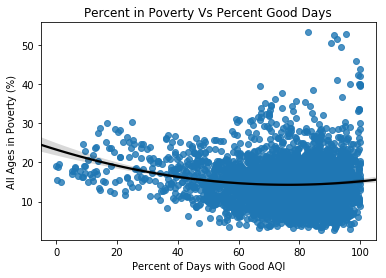

In [41]:
import seaborn

def plot_all_years_seaborn (df):
    
    ax2 = seaborn.regplot(df['PercentGoodDays'], df['PctBelowPoverty Population'],\
                          order=2,\
                         line_kws={"color":"black"})

    ax2.set_xlabel("Percent of Days with Good AQI")
    ax2.set_ylabel("All Ages in Poverty (%)")
    ax2.set_title(f"Percent in Poverty Vs Percent Good Days")
    
plot_all_years_seaborn(df)

In [42]:
# What points are in the upper right hand corner of the plot?
# These points appear to differ from the remaining data
outliers_df = df[(df['PercentGoodDays'] >= 80) & (df['PctBelowPoverty Population'] >= 30)]
outliers_df.State.value_counts()

Puerto Rico       15
Arizona            6
New Mexico         2
North Carolina     2
Tennessee          1
Florida            1
Ohio               1
South Carolina     1
Georgia            1
Name: State, dtype: int64

In [43]:
# Arizona Apache - reservation
# New Mexico McKinley - reservation
outliers_df[['State', 'County']]

,State,County
13,Arizona,Apache
336,New Mexico,McKinley
387,North Carolina,Robeson
479,Puerto Rico,Ponce
480,Puerto Rico,San Juan
626,Arizona,Apache
947,New Mexico,McKinley
1086,Puerto Rico,Ponce
1087,Puerto Rico,San Juan
1095,South Carolina,Darlington


                                   OLS Regression Results                                  
Dep. Variable:     Q("PctBelowPoverty Population")   R-squared:                       0.035
Model:                                         OLS   Adj. R-squared:                  0.032
Method:                              Least Squares   F-statistic:                     11.20
Date:                             Sat, 13 Apr 2019   Prob (F-statistic):           1.67e-05
Time:                                     04:28:43   Log-Likelihood:                -1951.0
No. Observations:                              613   AIC:                             3908.
Df Residuals:                                  610   BIC:                             3921.
Df Model:                                        2                                         
Covariance Type:                         nonrobust                                         
                                   coef    std err          t      P>|t|      [0

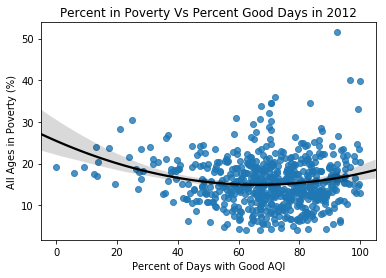

In [44]:
def fit_model_by_year (df, year):
    df_year = df[df.Year == year]
    
    ax2 = seaborn.regplot(df_year['PercentGoodDays'], df_year['PctBelowPoverty Population'],\
                          order = 2, line_kws={"color":"black"})

    ax2.set_xlabel("Percent of Days with Good AQI")
    ax2.set_ylabel("All Ages in Poverty (%)")
    ax2.set_title(f"Percent in Poverty Vs Percent Good Days in {year}")
    
    model = smf.ols(formula = 'Q("PctBelowPoverty Population") ~ PercentGoodDays + np.power(PercentGoodDays, 2)', data = df_year).fit()
    print(model.summary())

fit_model_by_year(df, 2012)

                                   OLS Regression Results                                  
Dep. Variable:     Q("PctBelowPoverty Population")   R-squared:                       0.034
Model:                                         OLS   Adj. R-squared:                  0.031
Method:                              Least Squares   F-statistic:                     10.76
Date:                             Sat, 13 Apr 2019   Prob (F-statistic):           2.56e-05
Time:                                     04:28:47   Log-Likelihood:                -1942.4
No. Observations:                              608   AIC:                             3891.
Df Residuals:                                  605   BIC:                             3904.
Df Model:                                        2                                         
Covariance Type:                         nonrobust                                         
                                   coef    std err          t      P>|t|      [0

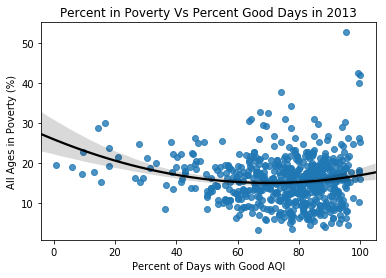

In [45]:
fit_model_by_year(df, 2013)

                                   OLS Regression Results                                  
Dep. Variable:     Q("PctBelowPoverty Population")   R-squared:                       0.027
Model:                                         OLS   Adj. R-squared:                  0.024
Method:                              Least Squares   F-statistic:                     8.462
Date:                             Sat, 13 Apr 2019   Prob (F-statistic):           0.000238
Time:                                     04:28:56   Log-Likelihood:                -1924.2
No. Observations:                              607   AIC:                             3854.
Df Residuals:                                  604   BIC:                             3868.
Df Model:                                        2                                         
Covariance Type:                         nonrobust                                         
                                   coef    std err          t      P>|t|      [0

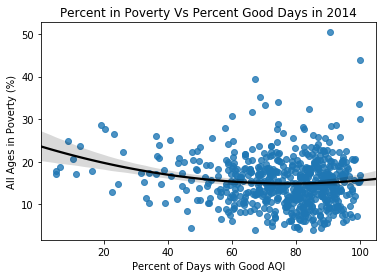

In [46]:
fit_model_by_year(df, 2014)

                                   OLS Regression Results                                  
Dep. Variable:     Q("PctBelowPoverty Population")   R-squared:                       0.027
Model:                                         OLS   Adj. R-squared:                  0.024
Method:                              Least Squares   F-statistic:                     8.515
Date:                             Sat, 13 Apr 2019   Prob (F-statistic):           0.000225
Time:                                     04:29:05   Log-Likelihood:                -1933.6
No. Observations:                              611   AIC:                             3873.
Df Residuals:                                  608   BIC:                             3886.
Df Model:                                        2                                         
Covariance Type:                         nonrobust                                         
                                   coef    std err          t      P>|t|      [0

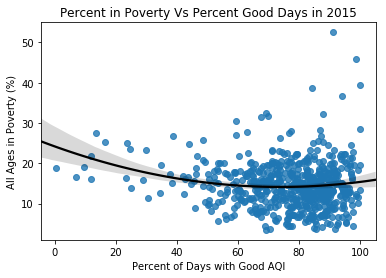

In [47]:
fit_model_by_year(df, 2015)

                                   OLS Regression Results                                  
Dep. Variable:     Q("PctBelowPoverty Population")   R-squared:                       0.016
Model:                                         OLS   Adj. R-squared:                  0.013
Method:                              Least Squares   F-statistic:                     5.062
Date:                             Sat, 13 Apr 2019   Prob (F-statistic):            0.00660
Time:                                     04:29:11   Log-Likelihood:                -1910.6
No. Observations:                              609   AIC:                             3827.
Df Residuals:                                  606   BIC:                             3840.
Df Model:                                        2                                         
Covariance Type:                         nonrobust                                         
                                   coef    std err          t      P>|t|      [0

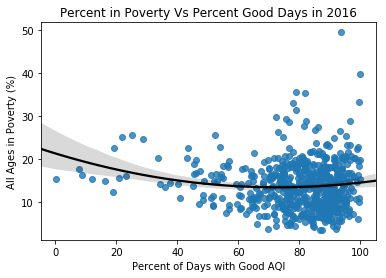

In [48]:
fit_model_by_year(df, 2016)

                                   OLS Regression Results                                  
Dep. Variable:     Q("PctBelowPoverty Population")   R-squared:                       0.010
Model:                                         OLS   Adj. R-squared:                  0.007
Method:                              Least Squares   F-statistic:                     3.024
Date:                             Sat, 13 Apr 2019   Prob (F-statistic):             0.0493
Time:                                     04:29:16   Log-Likelihood:                -1912.1
No. Observations:                              611   AIC:                             3830.
Df Residuals:                                  608   BIC:                             3843.
Df Model:                                        2                                         
Covariance Type:                         nonrobust                                         
                                   coef    std err          t      P>|t|      [0

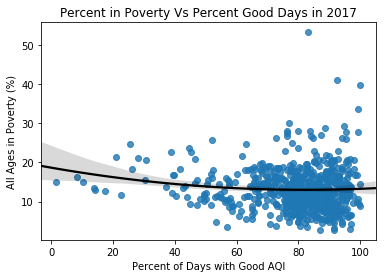

In [49]:
fit_model_by_year(df, 2017)

In [50]:
model = smf.ols(formula = 'Q("PctBelowPoverty Population") ~ PercentGoodDays + np.power(PercentGoodDays, 2) + Q("Total Population") + C(Year)', data = df).fit()
print(model.summary())

                                   OLS Regression Results                                  
Dep. Variable:     Q("PctBelowPoverty Population")   R-squared:                       0.052
Model:                                         OLS   Adj. R-squared:                  0.050
Method:                              Least Squares   F-statistic:                     24.99
Date:                             Sat, 13 Apr 2019   Prob (F-statistic):           7.93e-38
Time:                                     04:29:39   Log-Likelihood:                -11570.
No. Observations:                             3659   AIC:                         2.316e+04
Df Residuals:                                 3650   BIC:                         2.321e+04
Df Model:                                        8                                         
Covariance Type:                         nonrobust                                         
                                   coef    std err          t      P>|t|      [0

In [51]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['PopnScaled'] = scaler.fit_transform(df['Total Population'].values.reshape(-1,1))

C:\Users\Justin\Anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [52]:
model = smf.ols(formula = 'Q("PctBelowPoverty Population") ~ PercentGoodDays + np.power(PercentGoodDays, 2) + C(Year)', data = df).fit()
print(model.summary())

                                   OLS Regression Results                                  
Dep. Variable:     Q("PctBelowPoverty Population")   R-squared:                       0.047
Model:                                         OLS   Adj. R-squared:                  0.045
Method:                              Least Squares   F-statistic:                     25.66
Date:                             Sat, 13 Apr 2019   Prob (F-statistic):           1.80e-34
Time:                                     04:29:49   Log-Likelihood:                -11580.
No. Observations:                             3659   AIC:                         2.318e+04
Df Residuals:                                 3651   BIC:                         2.323e+04
Df Model:                                        7                                         
Covariance Type:                         nonrobust                                         
                                   coef    std err          t      P>|t|      [0

### Summary of Analysis

* There appears to be a small, negative association between the Percent of Good AQI Days and the All Ages in Poverty %
* This association is not statistically significant in each year when using the various measures of correlation (Pearson's r, Spearman's Rho, Kendall's tau).  It should be noted that the tests using Pearson's r require a linear relationship between the two variables (and bivariate normality).  Spearman's rho is Pearson's r applied to the ranked data and is looking for monotonic (not necessarily linear) relationships.  Kendall's tau is looking at concordance in the ranked data and is similar to Spearman's rho.  The test based on Kendall's tau is a test for dependence between two variables.
* The applicability of Pearson's r is questionable given that there appears to be a nonlinear relationship between the two variables.  This is seen in the plots with a quadratic polynomial fit by ordinary least squares regression.
* The quadratic term in the polynomial fits is significant in all of the models considered with the exception of the data from year 2017.
* The quadratic term is also significant in the multiple linear regressions that were fit
* There are several special cases where the percent of days with good AQI is large and the percent in poverty is large.  Further investigation of these cases shows that they are primarily data from Puerto Rico and reservations.  Removing these observations does not lessen the significance of the quadratic term.
* The fitted models have very low $R^2$ values.  This does not lessen the significance of the predictors; it implies that any prediction interval computed from the model will be wide.


The fitted model is as follows: 

Let $y = $ `PctBelowPoverty Population` and let $x = $ `PercentGoodDays`.  The regression equation is: $y = \beta_0 + \beta_1 I[\text{Year} = 2013] + \beta_2 I[\text{Year} = 2014] + \beta_3 I[\text{Year} = 2015] + \beta_4 I[\text{Year} = 2016]
+ \beta_5 I[\text{Year} = 2017] + \beta_6 x + \beta_7 x^2 + \epsilon$

* $I[\text{Year} = 2013] = 1$ if the Year is 2013 and is 0 otherwise.  The other indicator variables behave similarily.  The indicator variables allow for a different intercept in the fit based on the year.  The year 2012 corresponds to all indicator variables having the value of 0.  Hence $\beta_0$ is the intecept in the year 2012.  
* A more complex model with an interaction between `Year` and $x$ was also fit but not found to significantly improve the fit of the model.
* The regression model is fit via ordinary least squares regression.  The model is estimating the average value of $y$ as a function of $x$, `Year`. 
* From the fit of the model, as the percent of good AQI days ranges from 0 to 100, the percent of population below the poverty threshold decreases and the rate of decrease lessens until 73% good AQI days at which point the percent of population below the poverty threshold again starts to increase with the percent of good AQI days.


In [53]:
no_outliers_df = df[np.logical_not((df['PercentGoodDays'] >= 80) & (df['PctBelowPoverty Population'] >= 30))]
model = smf.ols(formula = 'Q("PctBelowPoverty Population") ~ PercentGoodDays + np.power(PercentGoodDays, 2) + C(Year)', data = no_outliers_df).fit()
print(model.summary())

                                   OLS Regression Results                                  
Dep. Variable:     Q("PctBelowPoverty Population")   R-squared:                       0.054
Model:                                         OLS   Adj. R-squared:                  0.052
Method:                              Least Squares   F-statistic:                     29.45
Date:                             Sat, 13 Apr 2019   Prob (F-statistic):           8.31e-40
Time:                                     04:29:58   Log-Likelihood:                -11159.
No. Observations:                             3629   AIC:                         2.233e+04
Df Residuals:                                 3621   BIC:                         2.238e+04
Df Model:                                        7                                         
Covariance Type:                         nonrobust                                         
                                   coef    std err          t      P>|t|      [0

In [54]:
# The full quadratic model with interactions - not a significant improvement.
model = smf.ols(formula = 'Q("PctBelowPoverty Population") ~ (PercentGoodDays + np.power(PercentGoodDays, 2))* C(Year)', data = df).fit()
print(model.summary())

                                   OLS Regression Results                                  
Dep. Variable:     Q("PctBelowPoverty Population")   R-squared:                       0.049
Model:                                         OLS   Adj. R-squared:                  0.045
Method:                              Least Squares   F-statistic:                     11.02
Date:                             Sat, 13 Apr 2019   Prob (F-statistic):           7.01e-30
Time:                                     04:30:01   Log-Likelihood:                -11576.
No. Observations:                             3659   AIC:                         2.319e+04
Df Residuals:                                 3641   BIC:                         2.330e+04
Df Model:                                       17                                         
Covariance Type:                         nonrobust                                         
                                                   coef    std err          t   

## Limitations of the study

* Limited number of years.  Additional years would show the change in AQI and Poverty over time in the US.
* The study can only look at AQI where the EPA has monitoring sites.  We have Poverty estimates from the ACS and CPS from the Census and BLS, repsectively, for all counties in the US.  
* AQI's computation changes over time https://en.wikipedia.org/wiki/Air_quality_index#United_States

In [ ]:
#Scott's Code

In [39]:
#Justin's Code
justin_df = pd.read_csv("census_and_epa.csv")
justin_df

#drop a couple columns that I don't plan to use and make a dataframe with only the variables I'm interested in analyzing
justin_df.drop(columns=['Total Male', 'Total Female', 'PctBelowPoverty Male', 'PctBelowPoverty Female', 'Unnamed: 0', 'Unnamed: 0.1'])
poverty_by_year_df = justin_df[['Year', 'PctBelowPoverty Population']]

# group some variables together to eventually make a dataframe
year_grouped_series = poverty_by_year_df.groupby(['Year'])
year_list = poverty_by_year_df['Year'].unique()
percent_poverty = year_grouped_series["PctBelowPoverty Population"].mean()

final_poverty_grouped_df = pd.DataFrame({"year": year_list, "Percent Below Poverty": percent_poverty})

# make some variables in preparation for making an easy-to-navigate graph
x_axis = year_list
poverty_points = final_poverty_grouped_df['Percent Below Poverty']


In [40]:
# group some variables together to make a dataframe
AQI_by_year_df = justin_df[['Year', 'Median AQI']]
year_grouped_series_AQI = AQI_by_year_df.groupby(['Year'])

median_AQI_series = year_grouped_series_AQI["Median AQI"].mean()

final_AQI_grouped_df = pd.DataFrame({"year": year_list, "Median AQI": median_AQI_series})

# make another variable for use in graphing
AQI_points = final_AQI_grouped_df['Median AQI']

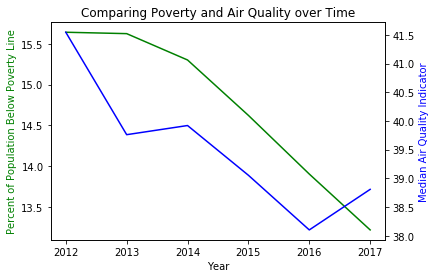

In [41]:
# making a graph with two y-axes comparing poverty and air quality
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x_axis, poverty_points, 'g-')
ax2.plot(x_axis, AQI_points, 'b-')



ax1.set_xlabel('Year')
ax1.set_ylabel('Percent of Population Below Poverty Line', color='g')
ax2.set_ylabel('Median Air Quality Indicator', color='b')
plt.title('Comparing Poverty and Air Quality over Time')
plt.savefig('poverty vs air quality plot', dpi=200)
plt.show()